In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFECV
from scipy.stats import pearsonr

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

**Load data from csv file.**

In [5]:
df = pd.read_csv('C:/SEAN/GA Tech Academics/Grad/Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Confusion/Dataset/EEG_data.csv')

In [6]:
# Drop the first two columns using iloc
df_mod = df.iloc[:, 2:]

df_mod.head()


,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


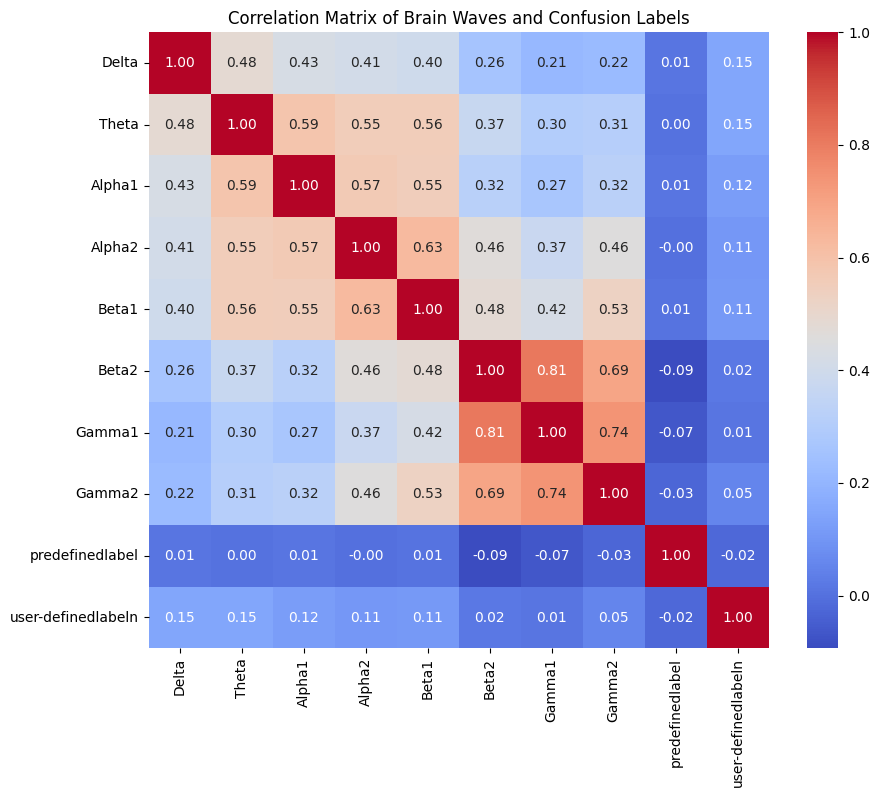

In [7]:
# 1. Investigate the relationship between Attention/mediation levels and brain wave frequencies
# Select relevant columns for brain waves and labels
wave_frequencies = ['Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2']
labels = ['predefinedlabel', 'user-definedlabeln']

# Calculate the correlation matrix
correlation_matrix = df[wave_frequencies  + labels].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Brain Waves and Confusion Labels')
plt.show()

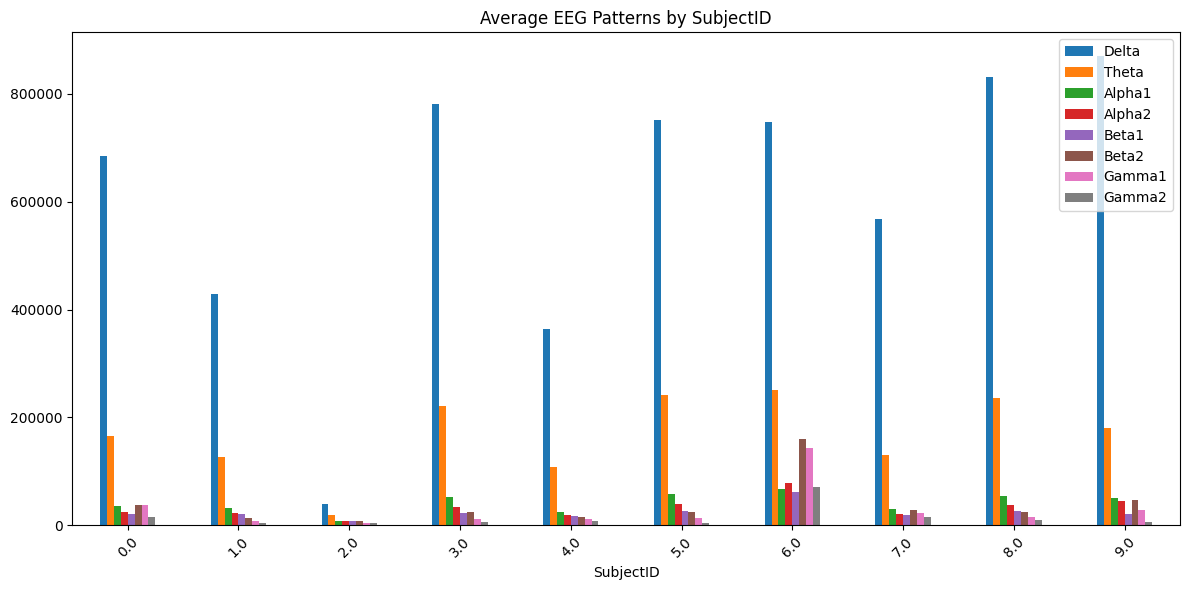

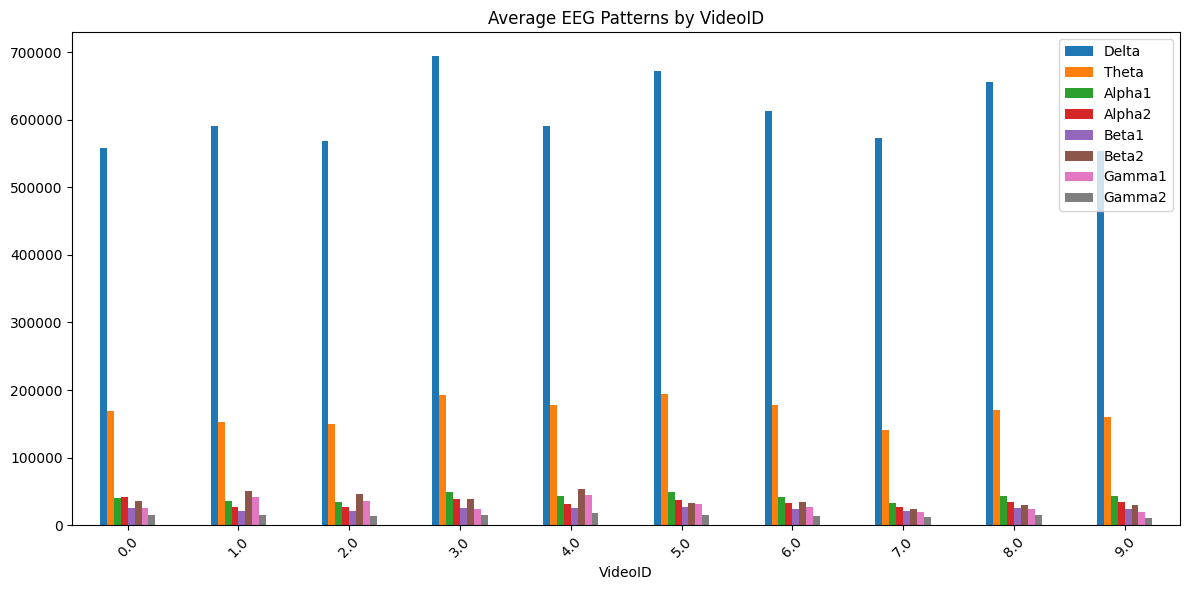

In [8]:
# 2. Analyze how the EEG patterns change across different SubjectIDs and VideoIDs
def plot_eeg_patterns(df, group_col):
    grouped = df.groupby(group_col)[wave_frequencies].mean()
    plt.figure(figsize=(12, 6))
    grouped.plot(kind='bar', ax=plt.gca())
    plt.title(f'Average EEG Patterns by {group_col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_eeg_patterns(df, 'SubjectID')
plot_eeg_patterns(df, 'VideoID')

In [10]:
# 3. Explore the significance of the binary classification in the 'user-definedlabeln' column
from scipy import stats
def compare_groups(df, column):
    group0 = df[df['user-definedlabeln'] == 0][column]
    group1 = df[df['user-definedlabeln'] == 1][column]
    t_stat, p_value = stats.ttest_ind(group0, group1)
    print(f"T-test results for {column}:")
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")
    print()

for column in ['Attention', 'Mediation'] + wave_frequencies:
    compare_groups(df, column)

T-test results for Attention:
T-statistic: 13.574605901700217
P-value: 1.0999219632651846e-41

T-test results for Mediation:
T-statistic: 2.6606475988152836
P-value: 0.007808772917771167

T-test results for Delta:
T-statistic: -17.005531619941234
P-value: 3.772982260620733e-64

T-test results for Theta:
T-statistic: -16.884963614328655
P-value: 2.8023265450259864e-63

T-test results for Alpha1:
T-statistic: -13.878081053151014
P-value: 1.7747099080157064e-43

T-test results for Alpha2:
T-statistic: -12.207281442543938
P-value: 4.394929825204466e-34

T-test results for Beta1:
T-statistic: -12.696274000759221
P-value: 1.0318241229431613e-36

T-test results for Beta2:
T-statistic: -2.213696632880805
P-value: 0.026867205091009257

T-test results for Gamma1:
T-statistic: -1.2808106610138783
P-value: 0.2002833683588075

T-test results for Gamma2:
T-statistic: -6.067395351443872
P-value: 1.336685308288256e-09



*   Attention and Mediation: Significant differences exist between the two groups (p-values are very low), meaning that attention and mediation levels are likely different for confused (1) vs. not confused (0) states.
*   Delta, Theta, Alpha1, Alpha2, Beta1, Beta2: Also show significant differences, with very small p-values, suggesting that these brain wave patterns differ substantially between the two groups. Delta and Theta are more important.
*   Gamma1 and Gamma2: Gamma1 shows no significant difference (p-value > 0.05), while Gamma2 has a significant difference, though less pronounced than other waves.




In [11]:
# Separate features and target variables
X = df[['Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2']]
y_confusion = df['user-definedlabeln']
y_attention = df['Attention']
y_mediation = df['Mediation']

In [12]:
# Function for feature selection
def perform_feature_selection(X, y):
    rfecv = RFECV(estimator=LinearRegression(), min_features_to_select=1,
                  scoring='neg_root_mean_squared_error', cv=5)
    rfecv.fit(X, y)
    kept_columns = X.columns[rfecv.support_]
    print("Kept columns:", kept_columns)
    return X.loc[:, kept_columns]

In [13]:
# Root mean squared error function
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Cross-validation with varying polynomial degrees
def k_folds_cross_validation(X: pd.DataFrame, y) -> int:
    training_errors = []
    cross_validation_errors = []

    for i in range(1, 8):
        # Create polynomial features
        poly = PolynomialFeatures(degree=i, include_bias=False)
        X_poly = poly.fit_transform(X)

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X_poly, y, train_size=0.8, random_state=42)

        # Create and fit the linear regression model
        linear_reg = LinearRegression(fit_intercept=False)
        model = linear_reg.fit(X_train, y_train)

        # Predict on the test data and compute RMSE
        y_pred = model.predict(X_test)
        rmse = root_mean_squared_error(y_test, y_pred)
        training_errors.append(rmse)

        # Perform 5-fold cross-validation and compute the mean RMSE
        cv = cross_validate(linear_reg, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, return_train_score=True)
        mean_cv_rmse = np.sqrt(np.abs(np.mean(cv['test_score'])))
        cross_validation_errors.append(mean_cv_rmse)

    # Visualize the training and cross-validation errors for each polynomial degree
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(range(1, 8), cross_validation_errors, label='Cross-Validation RMSE', marker='o')
    ax.set_xlabel('Polynomial Degree', fontsize=16)
    ax.set_ylabel('RMSE', fontsize=16)
    ax.set_title('Cross-Validation RMSE', fontsize=18)
    ax.legend(fontsize=12)
    plt.show()

    # Find and return the optimal polynomial degree
    optimal_degree = np.argmin(cross_validation_errors) + 1  # Add 1 because degrees start at 1
    return optimal_degree

In [14]:
# Feature selection for attention data
X_attention_preprocessed = perform_feature_selection(X, y_attention)

Kept columns: Index(['Gamma2'], dtype='object')


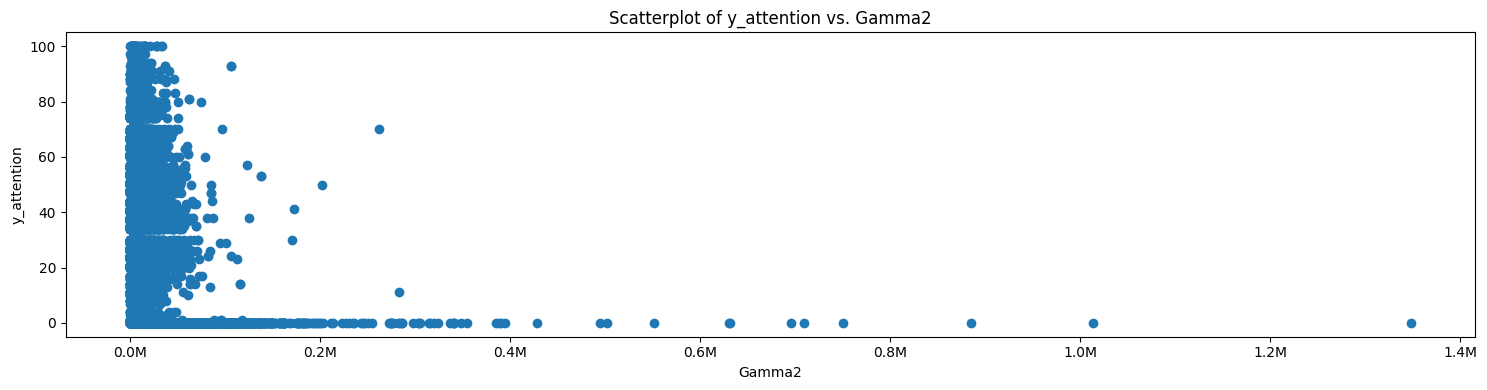

In [15]:
# Reformat function for millions
def reformat_millions(x, pos):
    return f'{x * 1e-6:.1f}M'

# Scatter plots for Attention
num_columns = X_attention_preprocessed.shape[1]
fig, axes = plt.subplots(nrows=1, ncols=num_columns, figsize=(15, 4))

if num_columns == 1:
    # If only one column, axes is a single Axes instance, not an array
    axes.scatter(X_attention_preprocessed.iloc[:, 0], y_attention)
    axes.set_xlabel(X_attention_preprocessed.columns[0])
    axes.set_ylabel('y_attention')
    axes.set_title(f'Scatterplot of y_attention vs. {X_attention_preprocessed.columns[0]}')
    axes.xaxis.set_major_formatter(FuncFormatter(reformat_millions))
else:
    for i, label in enumerate(X_attention_preprocessed.columns[:3]):  # Adjust to existing columns
        axes[i].scatter(X_attention_preprocessed[label], y_attention)
        axes[i].set_xlabel(label)
        axes[i].set_ylabel('y_attention')
        axes[i].set_title(f'Scatterplot of y_attention vs. {label}')
        axes[i].xaxis.set_major_formatter(FuncFormatter(reformat_millions))

plt.tight_layout()
plt.show()


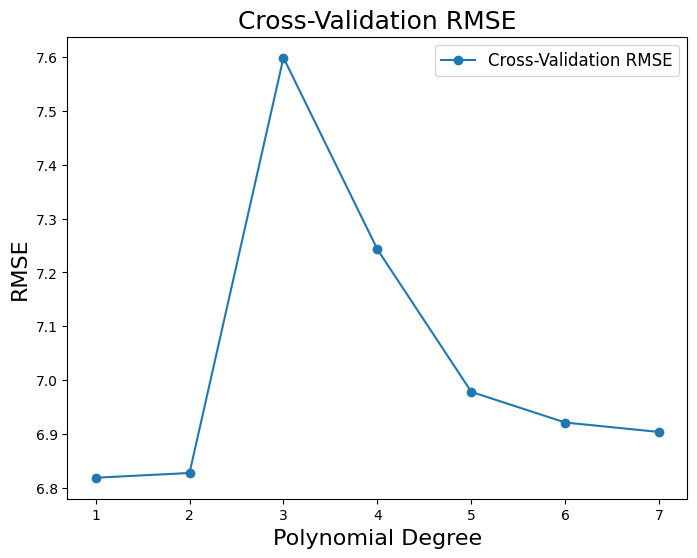

In [17]:
# Polynomial transformation for degree 2 based on cross-validation results
optimal_degree = k_folds_cross_validation(X_attention_preprocessed, y_attention)  # Determine the best degree
attention_poly = PolynomialFeatures(degree=optimal_degree, include_bias=False)
attention_poly_features = attention_poly.fit_transform(X_attention_preprocessed)


In [18]:
# Split the dataset into 80% training and 20% testing
X_attention_train, X_attention_test, y_attention_train, y_attention_test = train_test_split(
    attention_poly_features, y_attention, test_size=0.2, random_state=42)

In [19]:
# Fit the polynomial regression model
attention_poly_model = LinearRegression()
attention_poly_model.fit(X_attention_train, y_attention_train)

LinearRegression()

In [20]:
# Predict on the test data
attention_poly_y_pred = attention_poly_model.predict(X_attention_test)

In [21]:
# Calculate RMSE and R^2 Score
attention_poly_rmse = root_mean_squared_error(y_attention_test, attention_poly_y_pred)
attention_poly_r2 = r2_score(y_attention_test, attention_poly_y_pred)

# Print results
print(f"Root Mean Squared Error (RMSE): {attention_poly_rmse:.4f}")
print(f"R^2 Score: {attention_poly_r2:.4f}")

Root Mean Squared Error (RMSE): 22.0519
R^2 Score: 0.0962


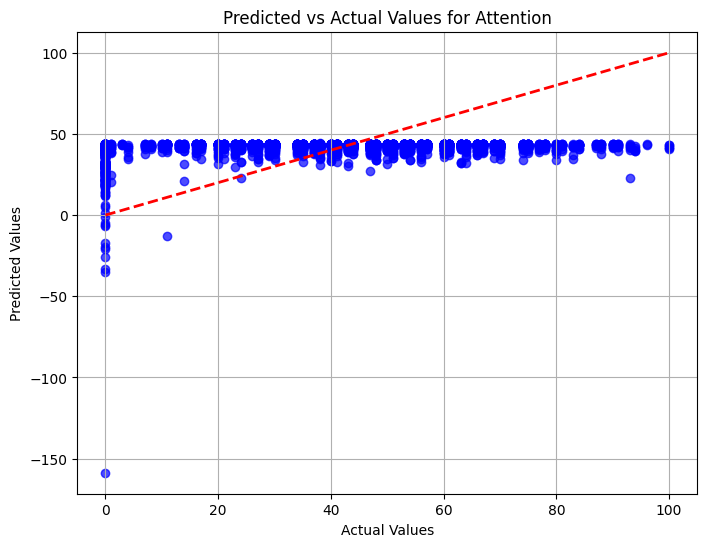

In [22]:
# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_attention_test, attention_poly_y_pred, alpha=0.7, color='blue')
plt.plot([y_attention_test.min(), y_attention_test.max()],
         [y_attention_test.min(), y_attention_test.max()],
         color='red', lw=2, linestyle='--')  # red = prediction line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values for Attention')
plt.grid(True)
plt.show()

In [23]:
# Feature selection for mediation data
X_mediation_preprocessed = perform_feature_selection(X, y_mediation)

Kept columns: Index(['Alpha1', 'Beta1', 'Beta2', 'Gamma2'], dtype='object')


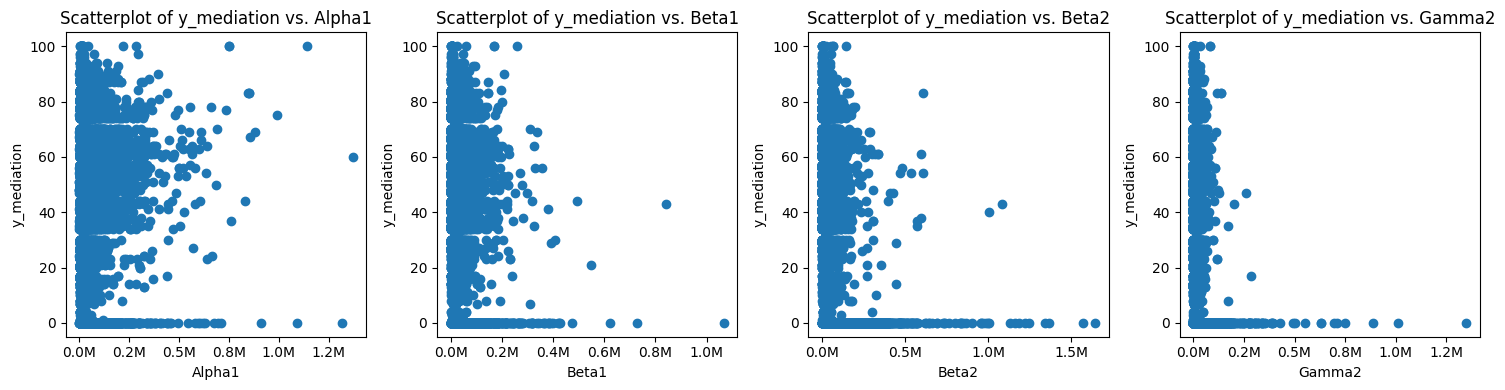

In [24]:
# Scatter plots for Mediation
num_columns_mediation = X_mediation_preprocessed.shape[1]
fig, axes = plt.subplots(nrows=1, ncols=num_columns_mediation, figsize=(15, 4))

if num_columns_mediation == 1:
    axes.scatter(X_mediation_preprocessed.iloc[:, 0], y_mediation)
    axes.set_xlabel(X_mediation_preprocessed.columns[0])
    axes.set_ylabel('y_mediation')
    axes.set_title(f'Scatterplot of y_mediation vs. {X_mediation_preprocessed.columns[0]}')
    axes.xaxis.set_major_formatter(FuncFormatter(reformat_millions))
else:
    for i, label in enumerate(X_mediation_preprocessed.columns[:4]):  # Adjust to existing columns
        axes[i].scatter(X_mediation_preprocessed[label], y_mediation)
        axes[i].set_xlabel(label)
        axes[i].set_ylabel('y_mediation')
        axes[i].set_title(f'Scatterplot of y_mediation vs. {label}')
        axes[i].xaxis.set_major_formatter(FuncFormatter(reformat_millions))

plt.tight_layout()
plt.show()

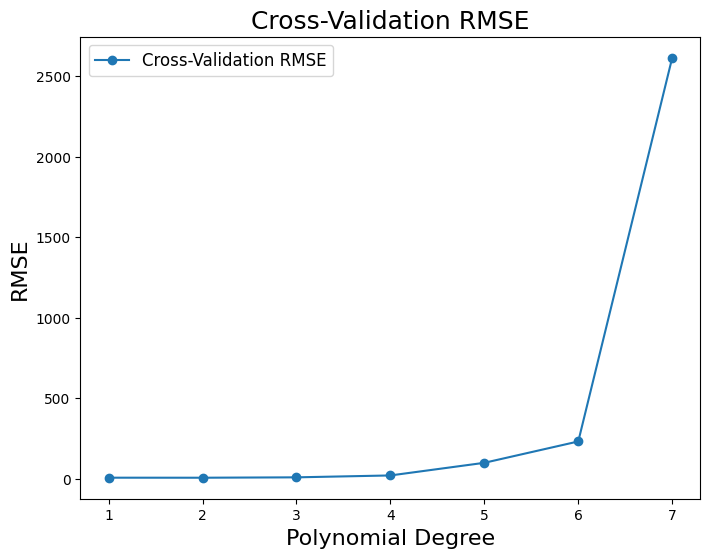

In [25]:
# Polynomial transformation for optimal degree based on cross-validation results for Mediation
optimal_degree_mediation = k_folds_cross_validation(X_mediation_preprocessed, y_mediation)
mediation_poly = PolynomialFeatures(degree=optimal_degree_mediation, include_bias=False)
mediation_poly_features = mediation_poly.fit_transform(X_mediation_preprocessed)

In [26]:
# Split the dataset into 80% training and 20% testing
X_mediation_train, X_mediation_test, y_mediation_train, y_mediation_test = train_test_split(
    mediation_poly_features, y_mediation, test_size=0.2, random_state=42)

In [27]:
# Fit the polynomial regression model
mediation_poly_model = LinearRegression()
mediation_poly_model.fit(X_mediation_train, y_mediation_train)

LinearRegression()

In [28]:
# Predict on the test data
mediation_poly_y_pred = mediation_poly_model.predict(X_mediation_test)

In [30]:
# Calculate RMSE and R^2 Score for Mediation
mediation_poly_rmse = root_mean_squared_error(y_mediation_test, mediation_poly_y_pred)
mediation_poly_r2 = r2_score(y_mediation_test, mediation_poly_y_pred)

# Print results for Mediation
print(f"Mediation - Root Mean Squared Error (RMSE): {mediation_poly_rmse:.4f}")
print(f"Mediation - R^2 Score: {mediation_poly_r2:.4f}")

Mediation - Root Mean Squared Error (RMSE): 19.2825
Mediation - R^2 Score: 0.2700


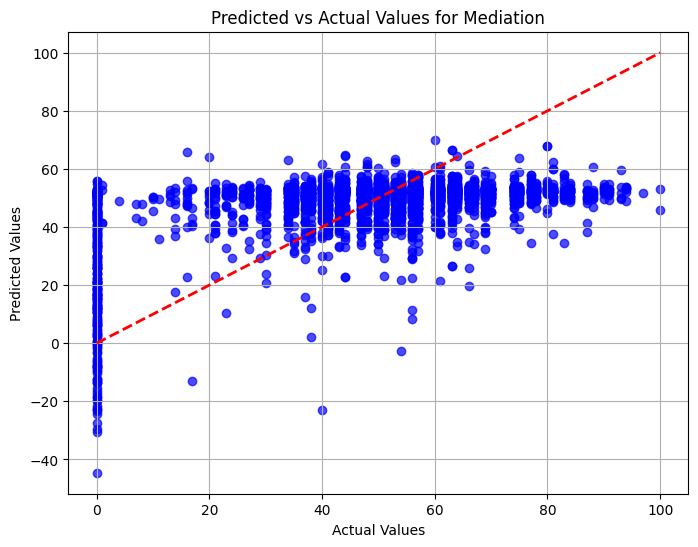

In [31]:
# Plot actual vs predicted values for Mediation
plt.figure(figsize=(8, 6))
plt.scatter(y_mediation_test, mediation_poly_y_pred, alpha=0.7, color='blue')
plt.plot([y_mediation_test.min(), y_mediation_test.max()],
         [y_mediation_test.min(), y_mediation_test.max()],
         color='red', lw=2, linestyle='--')  # red = prediction line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values for Mediation')
plt.grid(True)
plt.show()

In [33]:
# Feature selection for confusion data
X_confusion_preprocessed = perform_feature_selection(X, y_confusion)

Kept columns: Index(['Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1',
       'Gamma2'],
      dtype='object')


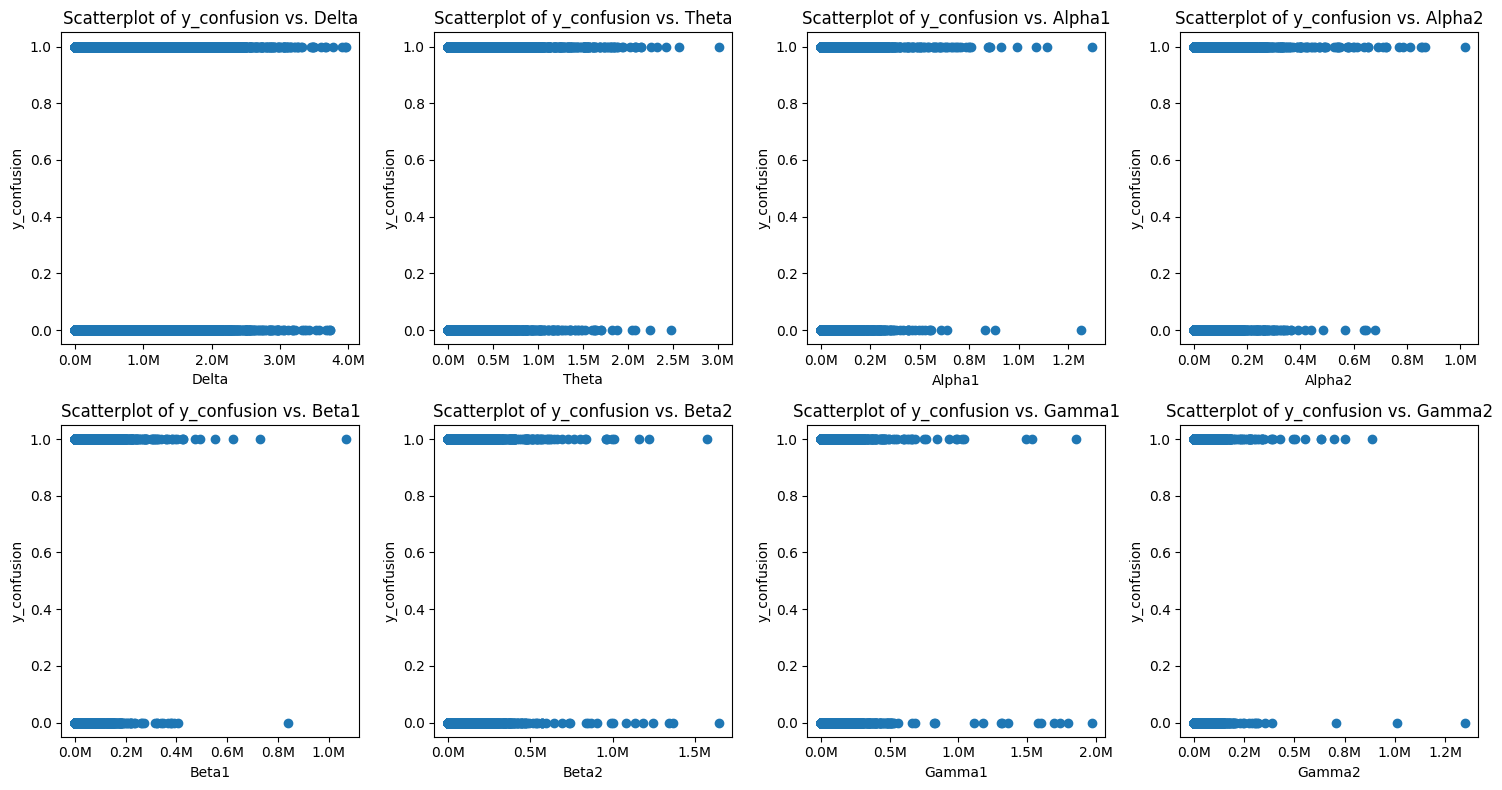

In [34]:
# Scatter plots for Confusion
num_columns_confusion = X_confusion_preprocessed.shape[1]

# Set up the figure with 2 rows and 4 columns
num_rows = 2
num_cols = 4
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 8))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each feature against the confusion state
for i, label in enumerate(X_confusion_preprocessed.columns[:8]):  # Adjust to existing columns
    axes[i].scatter(X_confusion_preprocessed[label], y_confusion)
    axes[i].set_xlabel(label)
    axes[i].set_ylabel('y_confusion')
    axes[i].set_title(f'Scatterplot of y_confusion vs. {label}')
    axes[i].xaxis.set_major_formatter(FuncFormatter(reformat_millions))

# Hide any unused subplots (if there are fewer than 8 features)
for j in range(i + 1, num_rows * num_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
optimal_degree_confusion = k_folds_cross_validation(X_confusion_preprocessed, y_confusion)

In [31]:
confusion_poly = PolynomialFeatures(degree=optimal_degree_confusion, include_bias=False)

In [32]:
confusion_poly_features = confusion_poly.fit_transform(X_confusion_preprocessed)

In [33]:
# Split the dataset into 80% training and 20% testing
X_confusion_train, X_confusion_test, y_confusion_train, y_confusion_test = train_test_split(
    confusion_poly_features, y_confusion, test_size=0.2, random_state=42)


In [34]:
# Fit the polynomial regression model
confusion_poly_model = LinearRegression()
confusion_poly_model.fit(X_confusion_train, y_confusion_train)

LinearRegression()

In [35]:
# Predict on the test data
confusion_poly_y_pred = confusion_poly_model.predict(X_confusion_test)


In [36]:
# Calculate RMSE and R^2 Score for Confusion
confusion_poly_rmse = root_mean_squared_error(y_confusion_test, confusion_poly_y_pred)
confusion_poly_r2 = r2_score(y_confusion_test, confusion_poly_y_pred)

# Print results for Confusion
print(f"Confusion - Root Mean Squared Error (RMSE): {confusion_poly_rmse:.4f}")
print(f"Confusion - R^2 Score: {confusion_poly_r2:.4f}")

Confusion - Root Mean Squared Error (RMSE): 0.4908
Confusion - R^2 Score: 0.0363


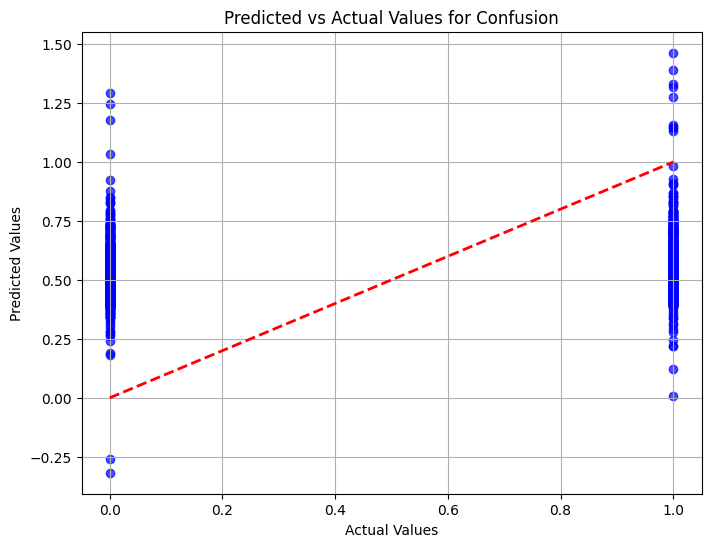

In [37]:
# Plot actual vs predicted values for Confusion
plt.figure(figsize=(8, 6))
plt.scatter(y_confusion_test, confusion_poly_y_pred, alpha=0.7, color='blue')
plt.plot([y_confusion_test.min(), y_confusion_test.max()],
         [y_confusion_test.min(), y_confusion_test.max()],
         color='red', lw=2, linestyle='--')  # red = prediction line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values for Confusion')
plt.grid(True)
plt.show()

Correlation between brain waves and confusion state:
Delta: 0.1486
Theta: 0.1476
Alpha1: 0.1217
Alpha2: 0.1072
Beta1: 0.1115
Beta2: 0.0196
Gamma1: 0.0113
Gamma2: 0.0535

The brain wave most correlated with confusion is Delta with a correlation of 0.1486


<ipython-input-38-a45f56b34d3c>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(correlations.keys()), y=list(correlations.values()), palette="viridis")


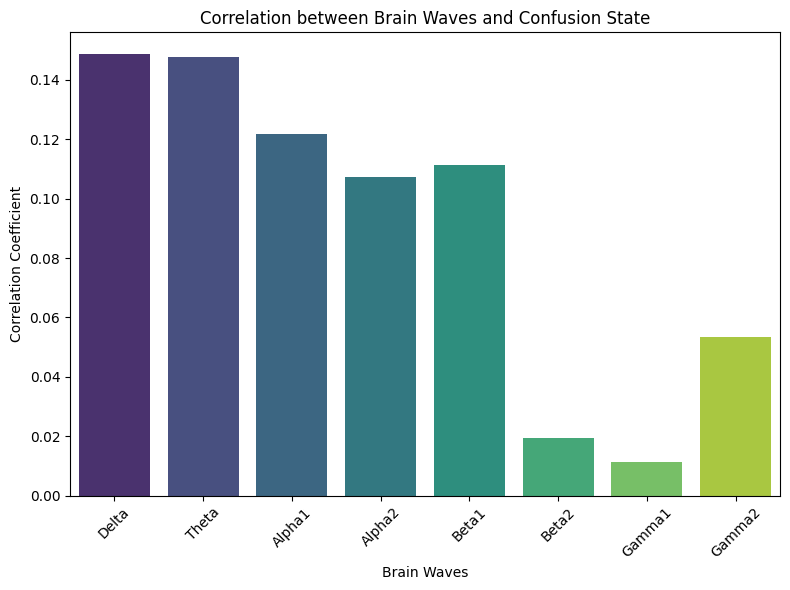

In [38]:
# Compute the correlation between each brain wave feature and the confusion state
brain_wave_features = ['Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2']
correlations = {}

# Loop through each brain wave feature and calculate the correlation with y_confusion
for feature in brain_wave_features:
    correlation = df[feature].corr(df['user-definedlabeln'])
    correlations[feature] = correlation

# Display the correlation results
print("Correlation between brain waves and confusion state:")
for wave, corr_value in correlations.items():
    print(f"{wave}: {corr_value:.4f}")

# Sort the brain waves by correlation value in descending order
sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

# Display the most correlated brain wave
most_correlated_wave = sorted_correlations[0][0]
most_correlated_value = sorted_correlations[0][1]
print(f"\nThe brain wave most correlated with confusion is {most_correlated_wave} with a correlation of {most_correlated_value:.4f}")

# Visualize the correlations using a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=list(correlations.keys()), y=list(correlations.values()), palette="viridis")
plt.title("Correlation between Brain Waves and Confusion State")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Brain Waves")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [43]:
# Function to train and evaluate models
def train_and_evaluate_models(X, y, poly_degree=1):
    # Polynomial transformation (default is linear)
    if poly_degree > 1:
        poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
        X = poly.fit_transform(X)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize models
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(),
        'Gradient Boosting': GradientBoostingRegressor(),
        'XGBoost': XGBRegressor()
    }

    # Store results
    results = {}

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[model_name] = {'RMSE': rmse, 'R2': r2}
        print(f"{model_name} - RMSE: {rmse:.4f}, R2: {r2:.4f}")

        # Plot actual vs predicted values
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.7)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Predicted vs Actual Values for {model_name}')
        plt.grid(True)
        plt.show()

    return results



Attention:
Linear Regression - RMSE: 22.0519, R2: 0.0962


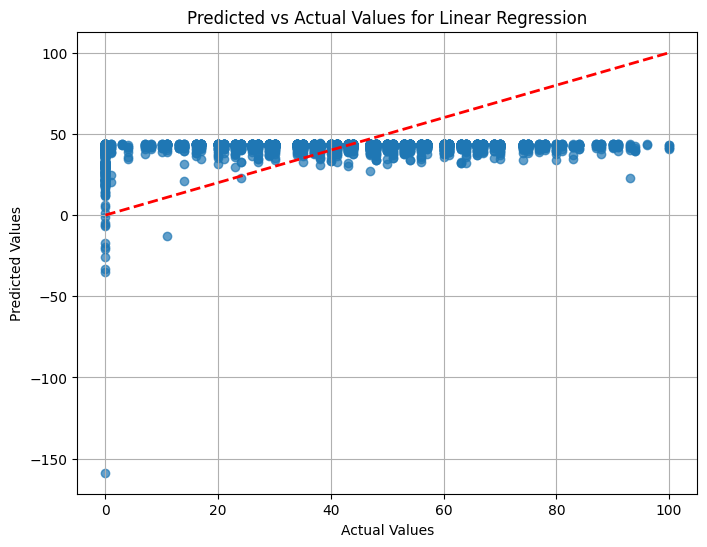

Random Forest - RMSE: 24.9384, R2: -0.1559


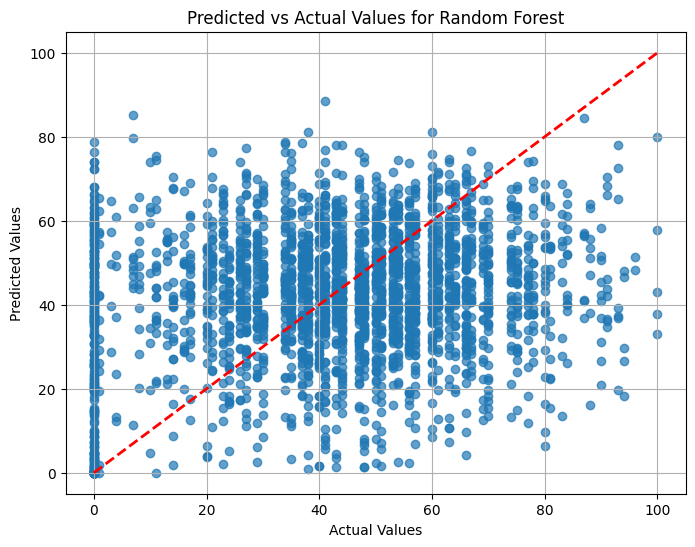

Gradient Boosting - RMSE: 21.2140, R2: 0.1636


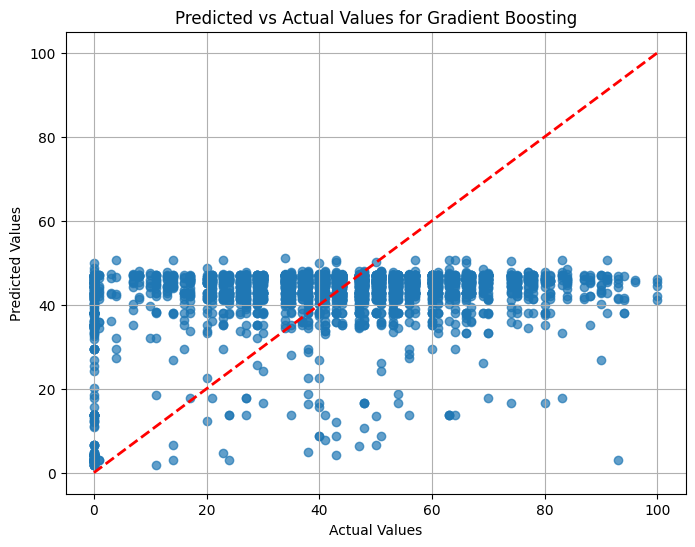

XGBoost - RMSE: 21.3941, R2: 0.1493


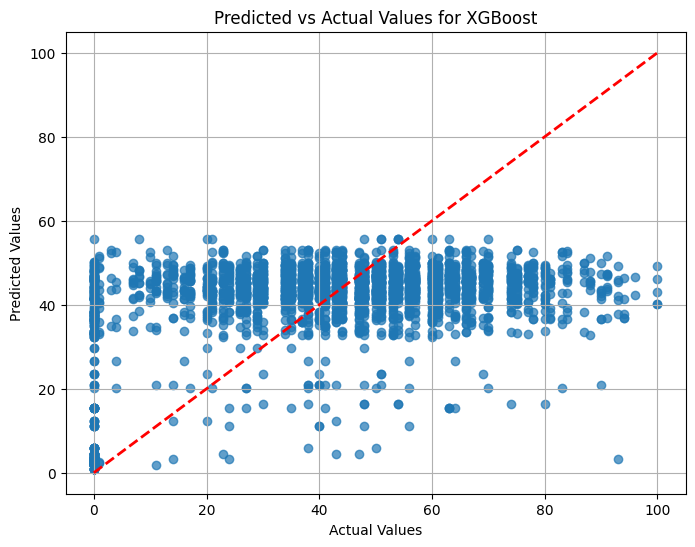

In [49]:
# Train and evaluate models for Attention
print("\nAttention:")
results_attention = train_and_evaluate_models(X_attention_preprocessed, y_attention, poly_degree=optimal_degree)




Mediation:
Linear Regression - RMSE: 19.2825, R2: 0.2700


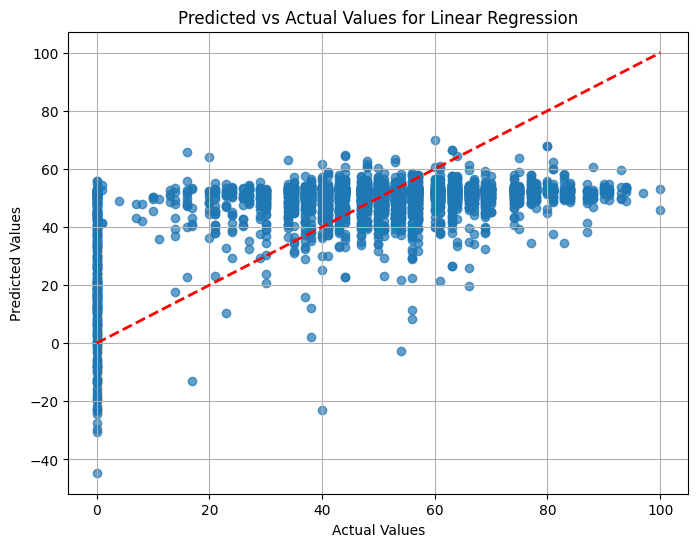

Random Forest - RMSE: 18.3699, R2: 0.3375


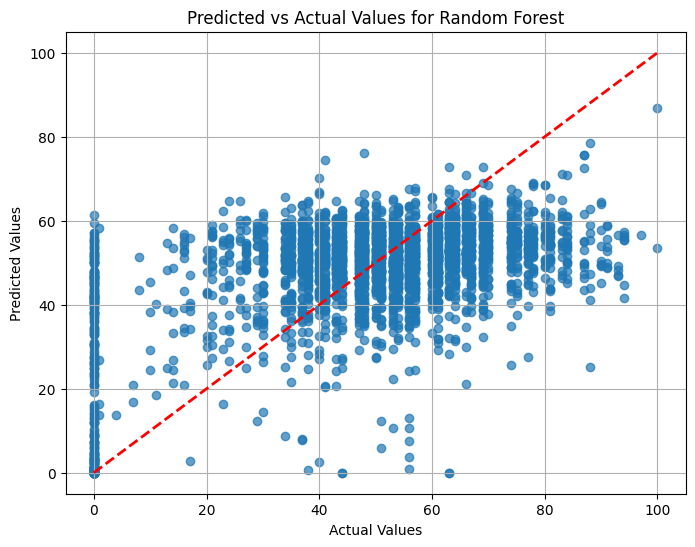

Gradient Boosting - RMSE: 18.3490, R2: 0.3390


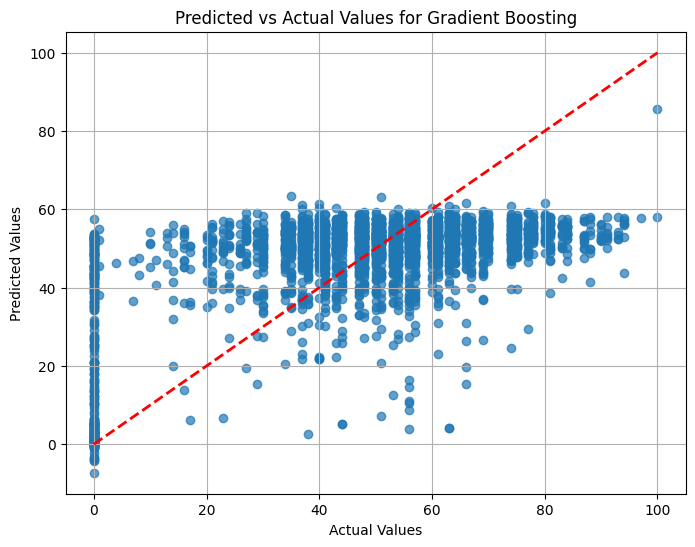

XGBoost - RMSE: 19.0160, R2: 0.2901


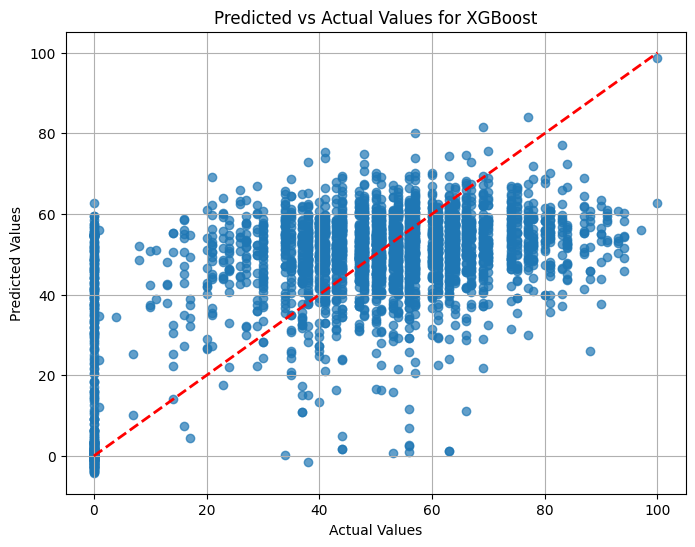

In [50]:
# Train and evaluate models for Mediation
print("\nMediation:")
results_mediation = train_and_evaluate_models(X_mediation_preprocessed, y_mediation, poly_degree=optimal_degree_mediation)


Confusion:
Linear Regression - RMSE: 0.4908, R2: 0.0363


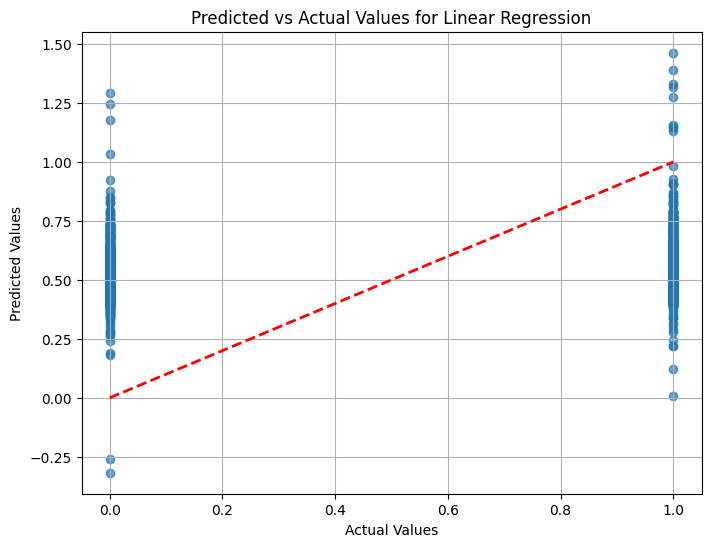

Random Forest - RMSE: 0.4680, R2: 0.1239


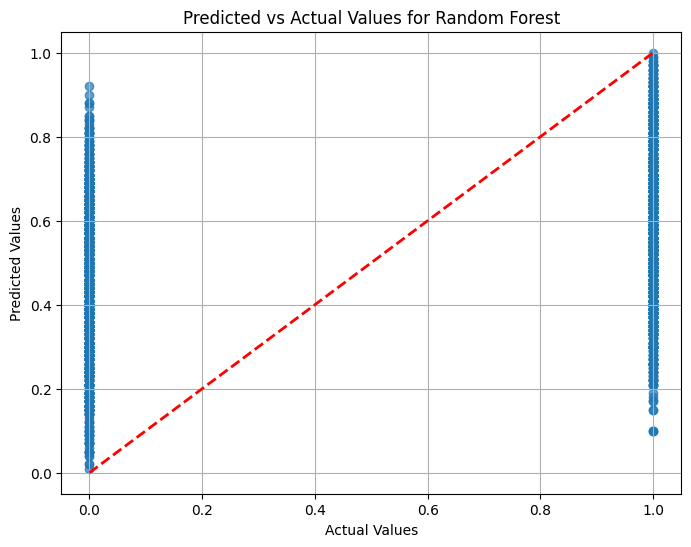

Gradient Boosting - RMSE: 0.4791, R2: 0.0819


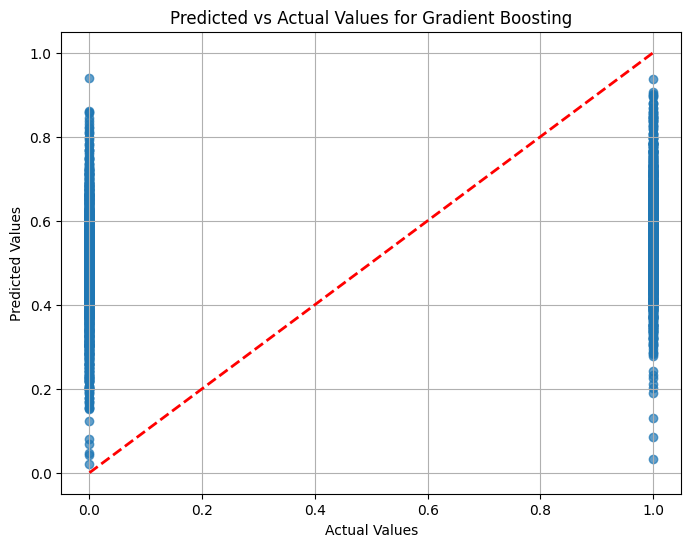

XGBoost - RMSE: 0.4932, R2: 0.0269


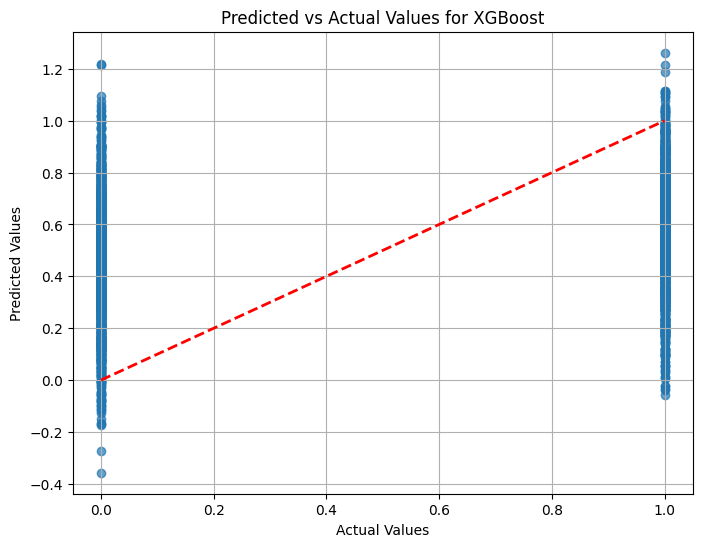

In [51]:
# Train and evaluate models for Mediation
print("\nConfusion:")
# Train and evaluate models using the optimal degree
results_confusion = train_and_evaluate_models(X_confusion_preprocessed, y_confusion, poly_degree=optimal_degree_confusion)